이미지 크기: (512, 512, 3)


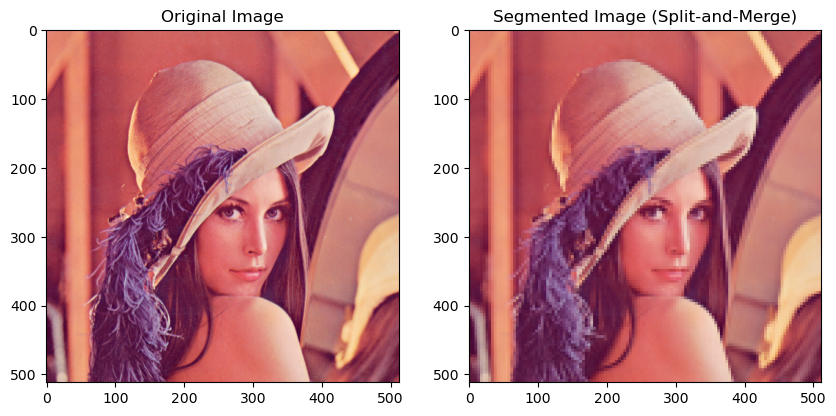

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 1. 컬러 이미지 로드
def load_image_as_color(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"이미지를 로드할 수 없습니다: {image_path}")
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)

# 2. 균질성 판단 (컬러 이미지용)
def is_homogeneous_color(region, s=10):
    if region.size == 0:
        return True
    # 각 채널(R, G, B)에 대해 분산 계산 후 평균
    variances = [np.var(region[:, :, i]) for i in range(3)]
    return np.mean(variances) < s

# 3. split 함수 (컬러 이미지용)
def split_color(region, s=10, min_size=4):
    h, w, c = region.shape
    
    if h <= min_size or w <= min_size:
        return [region]
    
    if is_homogeneous_color(region, s):
        return [region]
    
    h_half, w_half = h // 2, w // 2
    if h_half == 0 or w_half == 0:
        return [region]
    
    top_left = region[:h_half, :w_half]
    top_right = region[:h_half, w_half:]
    bottom_left = region[h_half:, :w_half]
    bottom_right = region[h_half:, w_half:]
    
    regions = []
    regions.extend(split_color(top_left, s, min_size))
    regions.extend(split_color(top_right, s, min_size))
    regions.extend(split_color(bottom_left, s, min_size))
    regions.extend(split_color(bottom_right, s, min_size))
    
    return regions

# 4. 분할-합병 알고리즘 (컬러 이미지용)
def split_and_merge_color(image, s=10, min_size=4):
    h, w, c = image.shape
    segmented_image = np.zeros_like(image)
    
    def fill_regions(img, y, x, h, w, s, min_size):
        region = img[y:y+h, x:x+w]
        if h <= min_size or w <= min_size or is_homogeneous_color(region, s):
            if region.size > 0:
                mean_value = np.mean(region, axis=(0, 1))  # RGB 평균
                segmented_image[y:y+h, x:x+w] = mean_value
            return
        
        h_half, w_half = h // 2, w // 2
        if h_half == 0 or w_half == 0:
            return
        
        fill_regions(img, y, x, h_half, w_half, s, min_size)
        fill_regions(img, y, x + w_half, h_half, w - w_half, s, min_size)
        fill_regions(img, y + h_half, x, h - h_half, w_half, s, min_size)
        fill_regions(img, y + h_half, x + w_half, h - h_half, w - w_half, s, min_size)

    fill_regions(image, 0, 0, h, w, s, min_size)
    return segmented_image

# 5. 결과 시각화 (컬러 이미지용)
def plot_results_color(original_img, segmented_img):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_img.astype(np.uint8))
    
    plt.subplot(1, 2, 2)
    plt.title("Segmented Image (Split-and-Merge)")
    plt.imshow(segmented_img.astype(np.uint8))
    plt.show()

# 6. 메인 실행 (컬러 이미지용)
if __name__ == "__main__":
    image_path = "./image/lena.bmp"  # 실제 이미지 경로로 변경
    color_image = load_image_as_color(image_path)
    print(f"이미지 크기: {color_image.shape}")
    
    # 분할-합병 알고리즘 적용
    s = 10  # 균질성 임계값 (분산 기준)
    min_size = 4  # 최소 지역 크기
    segmented_image = split_and_merge_color(color_image, s, min_size)
    
    # 결과 시각화
    plot_results_color(color_image, segmented_image)